In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Upload data
tw = pd.read_csv('../data/data_gwr.csv')

# Add population offset
tw['log_pop'] = np.log(tw['total_pop'])

variables = ['built_up_area', 'elevation']
variable_names = ['Built-up area', 'Elevation']
tw[variables].describe()

,built_up_area,elevation
count,349.000000,349.000000
mean,22.384484,220.282052
std,22.254940,368.830924
min,0.073000,0.704154
25%,4.796000,15.023594
50%,15.554000,71.961801
75%,32.746000,254.613109
max,99.001000,1965.409223


Text(0, 0.5, 'Frequency')

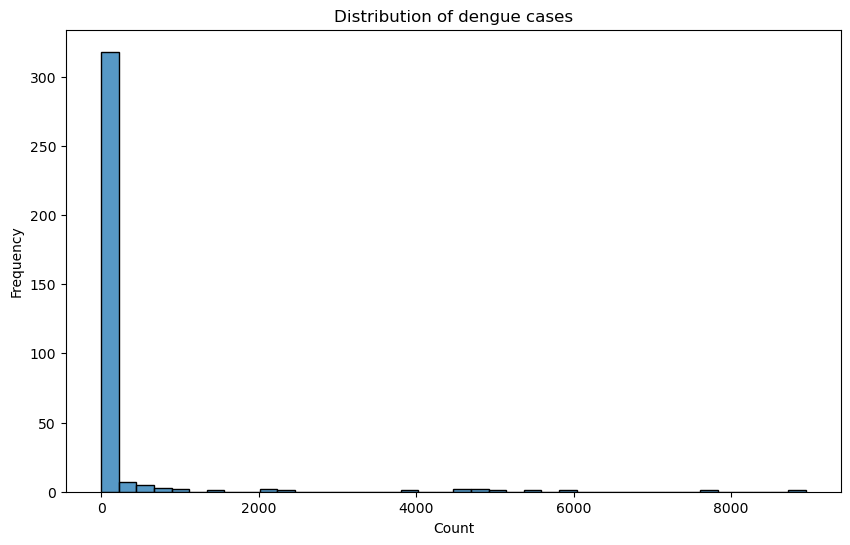

In [3]:
# Check the distribution of case counts
plt.figure(figsize=(10, 6))
sns.histplot(tw['case_count'], bins=40)
plt.title('Distribution of dengue cases')
plt.xlabel('Count')
plt.ylabel('Frequency')

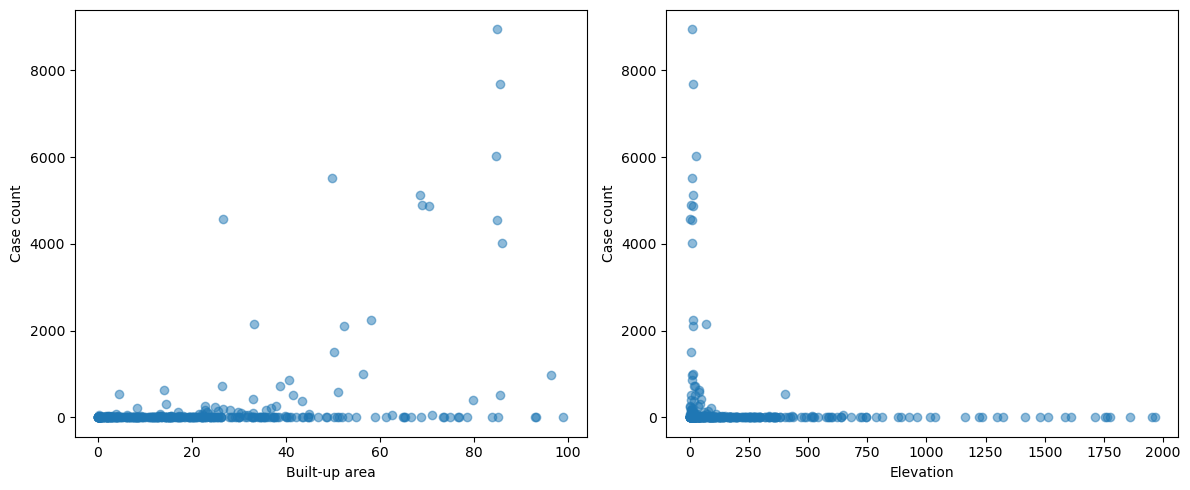

In [4]:
# Plot the relationships between dengue cases and non-climatic variables
plt.figure(figsize=(12, 5))

for i, variable in enumerate(variables):
    plt.subplot(1, 2, i+1)
    plt.scatter(tw[variable], tw['case_count'], alpha=.5)
    plt.xlabel(variable_names[i]) 
    plt.ylabel('Case count')
    plt.tight_layout()

In [5]:
# Check for overdispersion
mean_count = tw['case_count'].mean()
var_count = tw['case_count'].var()
dispersion = var_count / mean_count

print(f"Mean: {mean_count:.2f}")
print(f"Variance: {var_count:.2f}")
print(f"Dispersion ratio (variance/mean): {dispersion:.2f}")

Mean: 221.17
Variance: 985549.25
Dispersion ratio (variance/mean): 4456.03


In [6]:
# Define formula with non-climatic factors
nc_formula = "case_count ~ built_up_area + elevation"

# Model 1: Basic model
nbi_model = smf.glm(
    formula=nc_formula, 
    data=tw,
    family=sm.families.NegativeBinomial()
)
results1 = nbi_model.fit()
print("\nNegative Binomial Model Results (without offset):")
print(results1.summary())

# Model 2: With population offset 
nbi_model_pop = smf.glm(
    formula=nc_formula, 
    data=tw,
    family=sm.families.NegativeBinomial(),
    offset=tw['log_pop']
)
results2 = nbi_model_pop.fit()
print("\nNegative Binomial Model Results (with population offset):")
print(results2.summary())


Negative Binomial Model Results (without offset):
                 Generalized Linear Model Regression Results                  
Dep. Variable:             case_count   No. Observations:                  349
Model:                            GLM   Df Residuals:                      346
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1681.8
Date:                Fri, 25 Apr 2025   Deviance:                       1874.1
Time:                        16:45:36   Pearson chi2:                 6.52e+03
No. Iterations:                    16   Pseudo R-squ. (CS):             0.9578
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

/opt/homebrew/anaconda3/envs/dengue-data-exploration/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/homebrew/anaconda3/envs/dengue-data-exploration/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


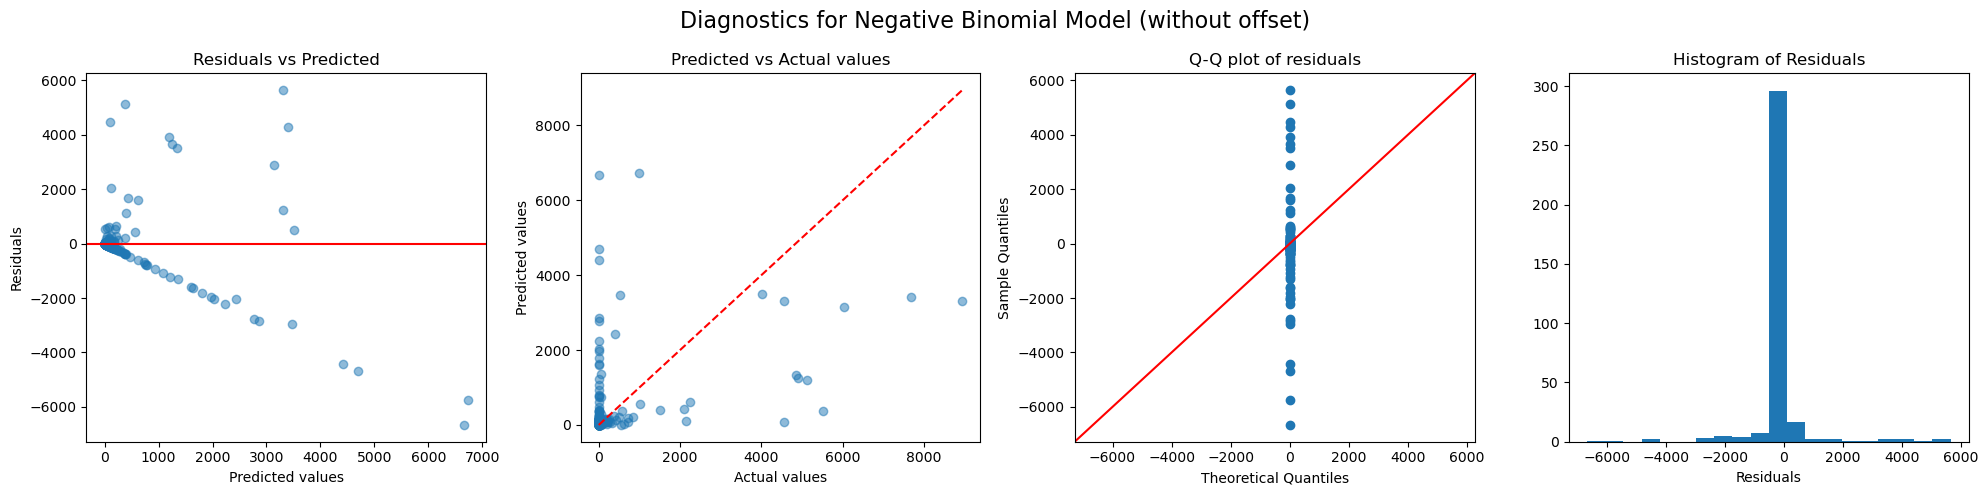

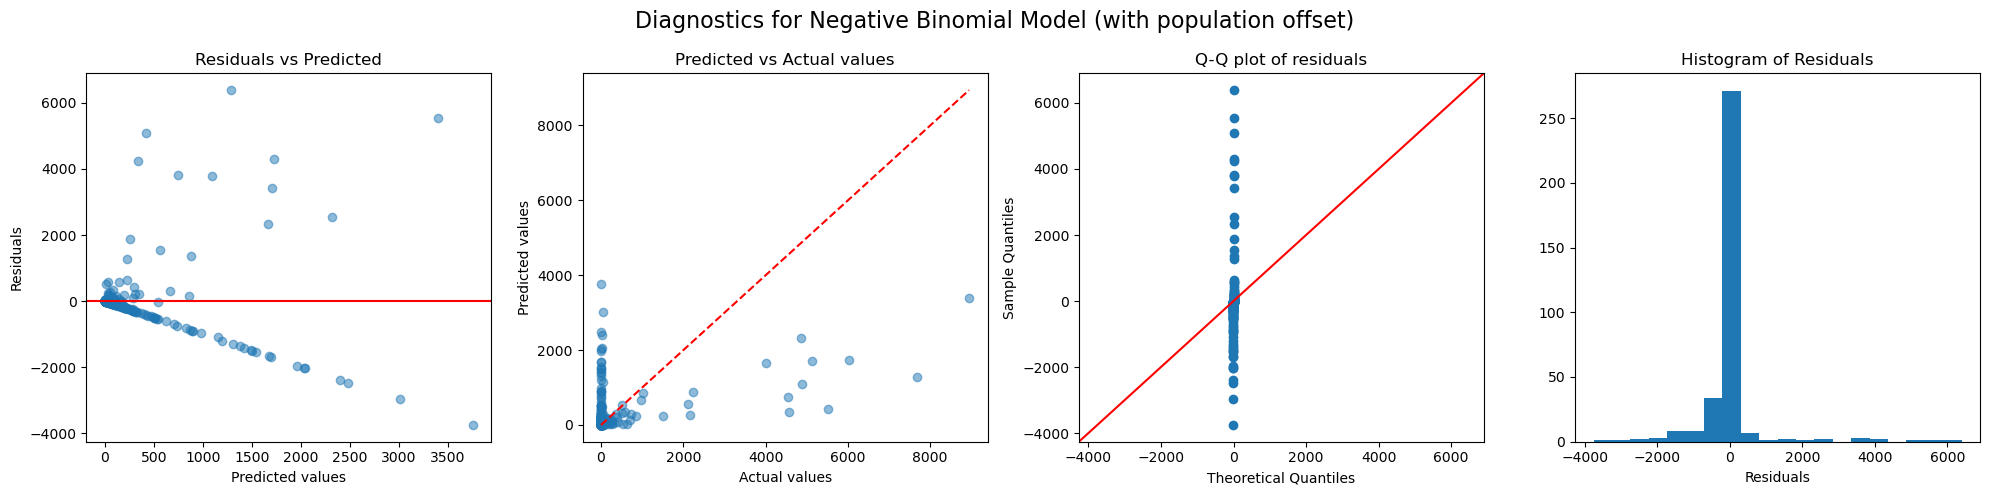

In [7]:
# Examine residuals for model diagnostics
results = [results1, results2]
model_names = ['Negative Binomial Model (without offset)', 'Negative Binomial Model (with population offset)']

for i, result in enumerate(results):
    f, ax = plt.subplots(1, 4, figsize=(20, 5))

    # Generate predicted values
    tw['predicted'] = result.predict()

    # Residuals
    ax[0].scatter(tw['predicted'], tw['case_count'] - tw['predicted'], alpha=.5)
    ax[0].axhline(y=0, color='r', linestyle='-')
    ax[0].set_title('Residuals vs Predicted')
    ax[0].set_xlabel('Predicted values')
    ax[0].set_ylabel('Residuals')

    # Actual vs predicted
    ax[1].scatter(tw['case_count'], tw['predicted'], alpha=.5)
    max_val = max(tw['case_count'].max(), tw['predicted'].max())
    ax[1].plot([0, max_val], [0, max_val], 'r--')
    ax[1].set_title('Predicted vs Actual values')
    ax[1].set_xlabel('Actual values')
    ax[1].set_ylabel('Predicted values')

    # Q-Q plot
    sm.qqplot(tw['case_count'] - tw['predicted'], line='45', ax=ax[2])
    ax[2].set_title('Q-Q plot of residuals')

    # Histogram of residuals
    ax[3].hist(tw['case_count'] - tw['predicted'], bins=20)
    ax[3].set_title('Histogram of Residuals')
    ax[3].set_xlabel('Residuals')

    plt.suptitle(f"Diagnostics for {model_names[i]}", fontsize=16)
    plt.tight_layout()